### EDA Transactional Data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath(os.path.join('..')))
from utilities.utils import convert_ccy

/Users/erinknochenhauer/.local/share/virtualenvs/silent_eight-IOYIP5YF/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trxns = pd.read_csv('../data/all_trxns.csv')
trxns.shape

(5302, 9)

In [3]:
trxns['timestamp'] = pd.to_datetime(trxns.timestamp)
# remove any non numeric characters while still keeping decimals.
trxns['amount'] = [re.sub("[^\d\.]", "", s) for s in trxns.amount]
trxns['amount'] = pd.to_numeric(trxns.amount)
trxns.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35


In [4]:
# The timezone was not given in the project brief, so I want to see if I can back into the timezone with simple histogram plots
trxns['hr_rounded'] = trxns.timestamp.dt.round("H").dt.hour
trxns.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,hr_rounded
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,6
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,3
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,22
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,22
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,0


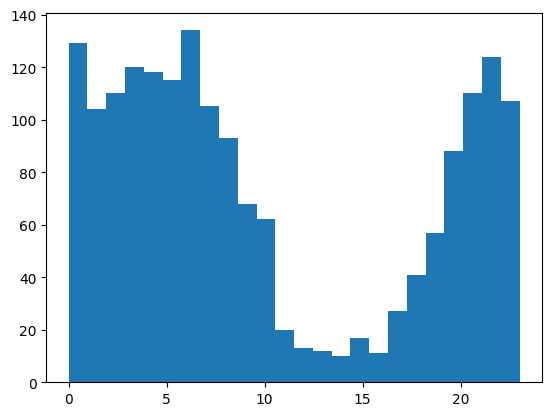

In [5]:
us = trxns[trxns.customer_country=='US']
plt.hist(us.hr_rounded, bins=24)
plt.show()

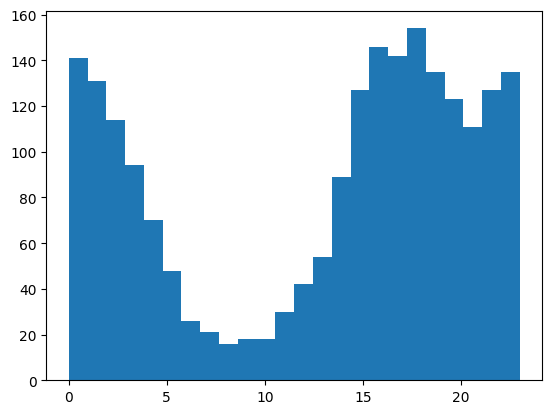

In [6]:
uk = trxns[trxns.customer_country=='UK']
plt.hist(uk.hr_rounded, bins=24)
plt.show()

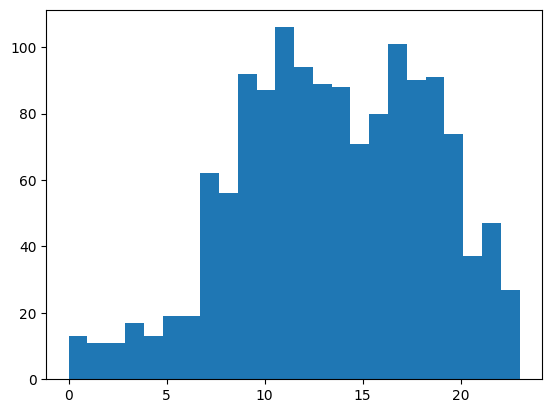

In [7]:
sg = trxns[trxns.customer_country=='SG']
plt.hist(sg.hr_rounded, bins=24)
plt.show()

Assuming the time is in Singapore time when seeing the graphs (i.e. makes most sense that transactions are lowest from midnight til 6 am when most people are sleeping). Convert US (assuming Eastern time) and UK to their local times to prep for feature engineering.

In [8]:
trxns['converted_time'] = np.where(trxns.customer_country=='US', trxns['timestamp'] - timedelta(hours=12),
                                np.where(trxns.customer_country=='UK', trxns['timestamp'] - timedelta(hours=8), trxns['timestamp']))

In [9]:
trxns.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,hr_rounded,converted_time
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,6,2021-03-19 21:59:25
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,3,2021-05-01 19:00:38
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,22,2021-05-23 14:15:15
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,22,2021-07-07 13:36:50
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,0,2021-09-01 16:14:03


In [10]:
trxns.customer_country.value_counts()

UK    2112
US    1795
SG    1395
Name: customer_country, dtype: int64

In [11]:
trxns.type.value_counts()

TRANSFER      716
TT            705
DIVIDEND      691
INTEREST      665
OTHER         649
PAYMENT       633
INVESTMENT    627
BILLING       616
Name: type, dtype: int64

In [12]:
trxns.ccy.value_counts()

GBP    1191
USD    1034
SGD     830
EUR     590
CNY     389
JPY     378
HKD     325
BRL     318
INR     247
Name: ccy, dtype: int64

In [13]:
# convert all to USD - using conversation rates as of Nov 5, 2023
trxns['converted_amount'] = [convert_ccy(amount, original_ccy) for amount, original_ccy in zip(trxns.amount, trxns.ccy)]
trxns

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,hr_rounded,converted_time,converted_amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,6,2021-03-19 21:59:25,330.6517
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,3,2021-05-01 19:00:38,23526.4194
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,22,2021-05-23 14:15:15,56691.2700
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,22,2021-07-07 13:36:50,48141.0594
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,0,2021-09-01 16:14:03,57247.3500
...,...,...,...,...,...,...,...,...,...,...,...,...
5297,R85394663171656,UK,N,2021-12-20 00:34:56,88635938895767,UK,INTEREST,GBP,25774.25,1,2021-12-19 16:34:56,29382.6450
5298,R85394663171656,UK,N,2021-12-23 17:49:44,88635938895767,UK,INTEREST,GBP,25660.33,18,2021-12-23 09:49:44,29252.7762
5299,R85394663171656,UK,N,2021-01-18 15:14:34,88635938895767,UK,OTHER,GBP,32242.92,15,2021-01-18 07:14:34,36756.9288
5300,R85394663171656,UK,N,2021-04-03 00:13:03,88635938895767,UK,OTHER,GBP,32139.62,0,2021-04-02 16:13:03,36639.1668


In [14]:
pd.options.display.float_format = '{:.2f}'.format
trxns.converted_amount.describe()

count      5302.00
mean      60740.27
std      323540.72
min           6.80
25%       16835.98
50%       37704.65
75%       56560.11
max     9175254.06
Name: converted_amount, dtype: float64

In [15]:
# Use standardscaler to standardize the transaction amount 
scaler = StandardScaler()
trxns['scaled_amount'] = scaler.fit_transform(np.asarray(trxns.converted_amount).reshape(-1,1))
trxns

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,hr_rounded,converted_time,converted_amount,scaled_amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,6,2021-03-19 21:59:25,330.65,-0.19
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,3,2021-05-01 19:00:38,23526.42,-0.12
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,22,2021-05-23 14:15:15,56691.27,-0.01
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,22,2021-07-07 13:36:50,48141.06,-0.04
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,0,2021-09-01 16:14:03,57247.35,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,R85394663171656,UK,N,2021-12-20 00:34:56,88635938895767,UK,INTEREST,GBP,25774.25,1,2021-12-19 16:34:56,29382.64,-0.10
5298,R85394663171656,UK,N,2021-12-23 17:49:44,88635938895767,UK,INTEREST,GBP,25660.33,18,2021-12-23 09:49:44,29252.78,-0.10
5299,R85394663171656,UK,N,2021-01-18 15:14:34,88635938895767,UK,OTHER,GBP,32242.92,15,2021-01-18 07:14:34,36756.93,-0.07
5300,R85394663171656,UK,N,2021-04-03 00:13:03,88635938895767,UK,OTHER,GBP,32139.62,0,2021-04-02 16:13:03,36639.17,-0.07


In [16]:
trxns.scaled_amount.describe()

count   5302.00
mean       0.00
std        1.00
min       -0.19
25%       -0.14
50%       -0.07
75%       -0.01
max       28.17
Name: scaled_amount, dtype: float64

In [17]:
# understand how many possible currencies occur when transaction is local to customer country
uk_example = trxns[(trxns.customer_country=='UK') & (trxns.counterparty_country=='UK')]
uk_example.ccy.value_counts()

GBP    211
EUR     27
JPY     21
USD     19
SGD     13
CNY     12
INR      8
HKD      6
BRL      1
Name: ccy, dtype: int64

In [18]:
# understand how many possible currencies occur when transaction is local to customer country
us_example = trxns[(trxns.customer_country=='US') & (trxns.counterparty_country=='US')]
us_example.ccy.value_counts()

USD    130
GBP     19
BRL     15
JPY      9
HKD      7
EUR      6
CNY      4
INR      3
SGD      2
Name: ccy, dtype: int64

It seems odd to me that a UK customer completing a transaction to a UK counterparty company would have any other currency then GBP. Could this be fraudulent? 

In [19]:
trxns.counterparty_country.value_counts()

CN               619
UK               614
JP               537
US               494
DE               484
FR               455
HK               453
BR               392
SG               375
IN               340
United States     23
USA               17
Name: counterparty_country, dtype: int64

In [20]:
# standardize country names
trxns['counterparty_country'] = np.where(trxns.counterparty_country.isin(['United States', 'USA']), 'US', trxns.counterparty_country)

In [21]:
trxns.isna().sum()

customer                  0
customer_country          0
fraud_flag                0
timestamp                 0
counterparty              0
counterparty_country    499
type                      0
ccy                       0
amount                    0
hr_rounded                0
converted_time            0
converted_amount          0
scaled_amount             0
dtype: int64

In [22]:
# some counterparty countries are missing but we have them available from other transactions, so impute country names that are missing with a dictionary.
no_missing_countries = trxns.dropna()
counterpart_country_map = dict(zip(no_missing_countries.counterparty, no_missing_countries.counterparty_country))

In [23]:
trxns['counterparty_country'] = trxns.counterparty_country.fillna(trxns.counterparty.apply(lambda x: counterpart_country_map.get(x)))
trxns.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,hr_rounded,converted_time,converted_amount,scaled_amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,6,2021-03-19 21:59:25,330.65,-0.19
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,3,2021-05-01 19:00:38,23526.42,-0.12
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,CN,PAYMENT,USD,56691.27,22,2021-05-23 14:15:15,56691.27,-0.01
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,CN,PAYMENT,CNY,343864.71,22,2021-07-07 13:36:50,48141.06,-0.04
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,CN,PAYMENT,USD,57247.35,0,2021-09-01 16:14:03,57247.35,-0.01


In [24]:
trxns.fraud_flag.value_counts()

N    5211
Y      91
Name: fraud_flag, dtype: int64

As expected, there are many more legitimate transactions than fraudulent transactions. We will need to rebalance the dataset before modeling to avoid always guessing N

In [25]:
trxns.to_csv('../data/preprocessed_trxns.csv', index=False)